# Online & Semi-Supervised SVM Exploration

__Daniel Coombs__

Looking into existing SVM approaches for online learning and semi-supervised learning. A very simple dataset is chosen such that it is easy to view the decision boundary in 2D.

Data - Moons dataset

Approaches:

1. SVM - scikit-learn, SVC
2. Online SVM - scikit-learn, kernel approximation->SGDClassifier
3. Semi-Supervised SVM (S3VM) - QN-S3VM

In [4]:
import sys
from os import path
sys.path.append("..")

import random, time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

## Data

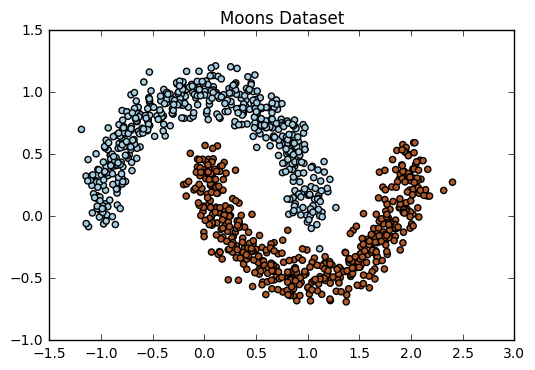

In [5]:
X, Y = datasets.make_moons(n_samples=1000, noise=0.1)

plt.scatter(X[:,0], X[:,1], c=Y, cmap=plt.cm.Paired)
plt.title('Moons Dataset')
plt.show()

## SVM

Standard SVM from scikit-learn. 3 cases are tested:
1. Linear kernel
2. RBF (non-linear) kernel
3. Non-linear input mapping approximating RBF, then linear kernel

In [6]:
# a few helper functions for kernel transformations

from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import PolynomialFeatures

def x_to_poly(x, degree=2):
    poly = PolynomialFeatures(degree)
    return poly.fit_transform(x)

def x_to_rbf(x, gamma=1.0, n=100):
    rbf_feature = RBFSampler(gamma=gamma, n_components=n, random_state=1)
    return rbf_feature.fit_transform(x)

In [7]:
from sklearn.svm import SVC, LinearSVC
from sklearn.kernel_approximation import RBFSampler

n_sample= len(X)
n_train = int(n_sample * 0.5)

X_train = X[:n_train]
Y_train = Y[:n_train]
X_test = X[n_train:]
Y_test = Y[n_train:]

# Linear
clf = SVC(kernel='linear')
clf.fit(X_train, Y_train)
score = clf.score(X_test, Y_test)
print('Linear classification score:', score)

# RBF
clf = SVC(kernel='rbf')
clf.fit(X_train, Y_train)
score = clf.score(X_test, Y_test)
print('RBF classification score:', score)

# NLIM + Linear
X_nlim = x_to_rbf(X, gamma=1)
X_train_nlim = X_nlim[:n_train]
X_test_nlim = X_nlim[n_train:]

clf = SVC(kernel='linear')
clf.fit(X_train_nlim, Y_train)
score = clf.score(X_test_nlim, Y_test)
print('NLIM+linear classification score:', score)

Linear classification score: 0.88
RBF classification score: 0.99
NLIM+linear classification score: 0.996


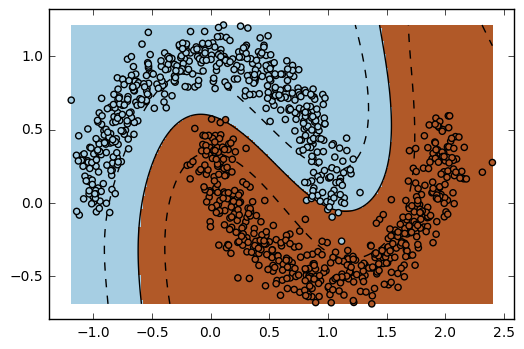

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired, zorder=10)

x_min = X[:, 0].min()
x_max = X[:, 0].max()
y_min = X[:, 1].min()
y_max = X[:, 1].max()

# Determine decision boundry
XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
#XX, YY = np.mgrid[-10:10:200j, -10:10:200j]
b_test = list(np.c_[XX.ravel(), YY.ravel()])

b_rbf = x_to_rbf(b_test, gamma=1)

Z = clf.decision_function(b_rbf)

# Put the result into a color plot
Z = Z.reshape(XX.shape)
plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
            levels=[-1, 0, 1])
plt.show()

### Kernel Approximation, Linear SVM using scikit-learn pipeline

In [9]:
from sklearn import pipeline

rbf_map = RBFSampler(gamma=1, random_state=1)
rbf_map_svm = pipeline.Pipeline([("feature_map", rbf_map), 
                                ("svm", LinearSVC())])

rbf_map_svm.set_params(feature_map__n_components=100)
rbf_map_svm.fit(X, Y)
rbf_map_svm.score(X_test, Y_test)

1.0

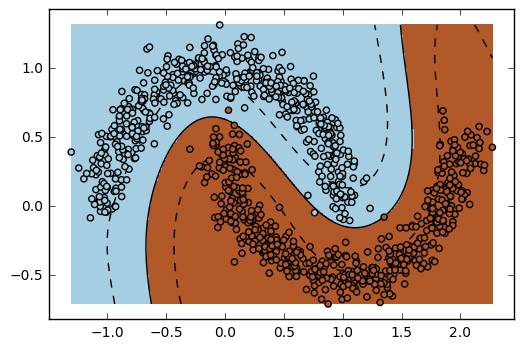

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired, zorder=10)

x_min = X[:, 0].min()
x_max = X[:, 0].max()
y_min = X[:, 1].min()
y_max = X[:, 1].max()

# Determine decision boundry
XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
#XX, YY = np.mgrid[-10:10:200j, -10:10:200j]
b_test = list(np.c_[XX.ravel(), YY.ravel()])

Z = rbf_map_svm.decision_function(b_test)

# Put the result into a color plot
Z = Z.reshape(XX.shape)
plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
            levels=[-1, 0, 1])
plt.show()

Clearly, on this dataset requrires a non-linear decision boundary. The linear SVM can only get 88.6% correct. An SVM with a true RBF kernel and a linear SVM with its inputs transformed to approximate a RBF kernel achive close to 100% performance. At least on this simple dataset, this shows the effectiveness of the kernel transformation

## Online SVM

Using SGDClassifer from scikit-learn on the transformed input 3 different modes are tested:
1. Full-batch SGD
2. Online SGD
3. Mini-batch SGD

In [10]:
from sklearn.linear_model import SGDClassifier

# SGD on all train data, hinge loss gives linear SVM
clf = SGDClassifier(loss='hinge', penalty='l2')
clf.fit(X_train_nlim, Y_train)
score = clf.score(X_test_nlim, Y_test)

# Online SGD
score_isgd = np.zeros(len(X_train_nlim))
clf = SGDClassifier(loss='hinge', penalty='l2')
clf.partial_fit(X_train_nlim[0].reshape(1,-1), Y_train[0].reshape(1),
                classes=np.unique(Y))

for i in range(1, len(X_train_nlim)):
    clf.partial_fit(X_train_nlim[i].reshape(1,-1), Y_train[i].reshape(1))
    score_isgd[i] = clf.score(X_test_nlim, Y_test)

# Mini-batch SGD
batch_size = 10
score_bsgd = np.zeros(len(X_train_nlim))
clf = SGDClassifier(loss='hinge', penalty='l2')
clf.partial_fit(X_train_nlim[0:batch_size], Y_train[0:batch_size], classes=[0,1])

i = 1
while (i+1)*batch_size < len(X_train):
    clf.partial_fit(X_train_nlim[batch_size*i:batch_size*(i+1)],
                    Y_train[batch_size*i:batch_size*(i+1)])   
    score_bsgd[i] = clf.score(X_test_nlim, Y_test)
    i += 1

Full-batch SGD classification score: 0.996
Final online SGD classification score 0.656
Final mini-batch SGD classification score 0.994


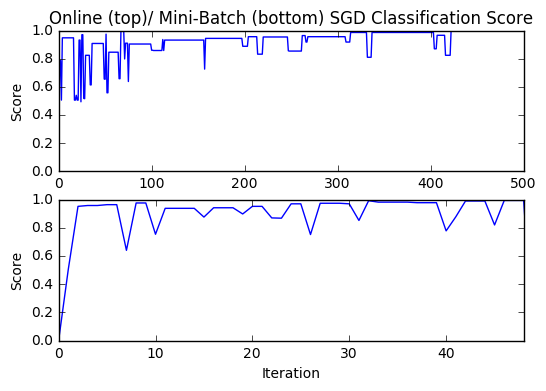

In [11]:
print('Full-batch SGD classification score:', score)    
print('Final online SGD classification score', score_isgd[i])    
print('Final mini-batch SGD classification score', score_bsgd[i-1]) 

plt.subplot(2, 1, 1)
plt.plot(score_isgd)
plt.title('Online (top)/ Mini-Batch (bottom) SGD Classification Score')
plt.ylabel('Score')

plt.subplot(2, 1, 2)
plt.plot(score_bsgd)
plt.xlim([0, i-1])
plt.xlabel('Iteration')
plt.ylabel('Score')

plt.show()

## Semi-Supervised SVM

A visualization of semi-supervised learning in SVMs using the [QN-S3VM](http://www.fabiangieseke.de/index.php/code/qns3vm) developed by Gieseke et al.

In [10]:
from svm.qns3vm import QN_S3VM

my_random_generator = random.Random()
my_random_generator.seed(0)

# QN_S3VM expects binary -1,1 data
Y[Y == 0] = -1

# partition into labeled, unlabeled, and test
n_sample = len(X)
n_label = int(0.01 * n_sample)
n_unlabel = int(0.49 * n_sample)

X_label = X[:n_label]
Y_label = Y[:n_label]
X_unlabel = X[n_label:n_label + n_unlabel]
X_test = X[n_label + n_unlabel:]
Y_test = Y[n_label + n_unlabel:]

In [11]:
t_start = time.time()

model = QN_S3VM(list(X_label), list(Y_label), list(X_unlabel), my_random_generator,
                lam=0.0009765625, lamU=1, kernel_type="RBF", sigma=0.5,  estimate_r=0.0,)
model.train()

t_end = time.time()
t_elapsed = t_end - t_start
print('Training Time:', t_elapsed)

preds = np.asarray(model.getPredictions(X_test))
error_cnt = np.sum(preds != Y_test)
error = error_cnt / Y_test.size
print('Error Rate', error)
print('Score', 1-error)

Training Time: 0.773608922958374
Error Rate 0.0
Score 1.0


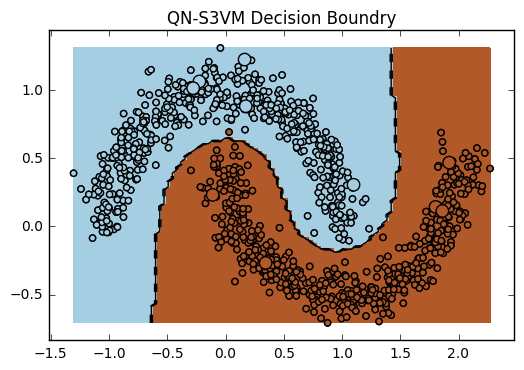

In [13]:
# Visualization of the decision boundry

# Plot labeled data
plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired)
plt.scatter(X_label[:, 0], X_label[:, 1], c=Y_label, s=80, cmap=plt.cm.Paired, zorder=10)

x_min = X[:, 0].min()
x_max = X[:, 0].max()
y_min = X[:, 1].min()
y_max = X[:, 1].max()

# Plot decision boundry
XX, YY = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
b_test = list(np.c_[XX.ravel(), YY.ravel()])
Z = model.getPredictions(b_test, real_valued=True)

# Put the result into a color plot
Z = np.asarray(Z)
Z = Z.reshape(XX.shape)
plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
            levels=[-.5, 0, .5])
plt.title('QN-S3VM Decision Boundry')
plt.show()